# Hands-On Optimization in Deep Learning @ MATH+ Summer School
Welcome to the Math+ summer school session Mathematical Optimization for Machine Learning! In this notebook, we'll explore different optimization algorithms and their impact on training neural networks.

In the following, we will cover some of the most popular (first-order) optimization algorithms for training neural networks. We will use the [PyTorch](https://pytorch.org/) framework for this purpose. If you are not familiar with PyTorch, you can find a short introduction [here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

We will focus on the following first-order optimization algorithms:
- Stochastic Gradient Descent (SGD)
- SGD with Momentum
- Nesterov Accelerated Gradient (NAG) or SGD with Nesterov Momentum
- Adaptive Gradient Algorithm (AdaGrad)
- Adaptive Moment Estimation (Adam)

# Setup
Before we start, we need to import some packages and define some helper functions. We will use the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database/) for our experiments. The MNIST dataset consists of 28x28 grayscale images of handwritten digits (0-9) and is a popular benchmark dataset for image classification. 

We will use the [torchvision](https://pytorch.org/docs/stable/torchvision/index.html) package to download the dataset.

1. **Preliminaries:** Install and import packages
2. **Data Preprocessing:** Prepare MNIST dataset
3. **Model Initialization:** Define Neural Network architecture (Multi-Layer Perceptron)
4. **Helper Functions:** Define training and evaluation functions
5. **Coding Exercise:** Code your own optimizers like msgd, SGD with Momentum, SGD with Nesterov Momentum, AdaGrad, Adam
6. **Train and Test:** Train and evaluate your model with your optimizers
6. **Evaluation:** Compare the different optimizers


# 1) Preliminaries: Installation and Imports

In [ ]:
!pip3 install numpy matplotlib torch torchvision

In [2]:
# Setup: Import necessary libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

## 2) Data Preprocessing

Let's load and preprocess the MNIST dataset. 

- Normalization/standardization is important for convergence rates. We normalize the data to have approximately zero mean and unit variance.
- We also convert the labels to one-hot encoded vectors.
- Finally, we split the dataset into training and validation sets.
- We use the validation set to evaluate the model's performance on unseen data.

<figure >
  <img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" alt="MNIST" style="width: 30%; margin: 0 auto;">
  <figcaption>Figure 1: Examples from the MNIST dataset. Image Source: Wikimedia Commons</figcaption>
</figure>


In [3]:
# Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Transform data to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
dataset = MNIST(root='./data', download=True, transform=transform)

# Split the dataset into training, validation, and test sets
train_set, val_set = random_split(dataset, [50000, 10000])
test_set = MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

print(f"Training Samples: {len(train_set)}")
print(f"Validation Samples: {len(val_set)}")
print(f"Testing Samples: {len(test_set)}")

Training Samples: 50000
Validation Samples: 10000
Testing Samples: 10000


## 3) Model Initialization

Now, let's define a very simple feed-forward neural network to serve as our baseline model. This model consists of a single hidden layer with 128 neurons and a ReLU activation function. The output layer consists of 10 neurons, one for each class, and a softmax activation function.

In [4]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the model and move it to the device
model = SimpleNN().to(device)
print(model)

# Loop over the parameters
for name, param in model.named_parameters():
    print(f"Name: {name}, Shape: {param.shape}")

for param in model.parameters():
    print(param.shape)

SimpleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Name: fc1.weight, Shape: torch.Size([128, 784])
Name: fc1.bias, Shape: torch.Size([128])
Name: fc2.weight, Shape: torch.Size([10, 128])
Name: fc2.bias, Shape: torch.Size([10])
torch.Size([128, 784])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


## 4) Helper Functions: Training and Evaluation Routines

Let's first define our training and evaluation functions, which will be used later for training and evaluating our model. We will use the cross-entropy loss function, which is commonly used for classification problems. 

In [5]:
# Define the loss and metrics
criterion = nn.CrossEntropyLoss()

# Define the training function
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)

# Define the evaluation function
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
    accuracy = correct_predictions / len(dataloader.dataset)
    return running_loss / len(dataloader.dataset), accuracy

# Gradient Descent Optimization Algorithms

As stated above, we will focus on the following first-order optimization algorithms:
- Stochastic Gradient Descent (SGD)
- SGD with Momentum
- Nesterov Accelerated Gradient (NAG) or SGD with Nesterov Momentum
- Adaptive Gradient Algorithm (AdaGrad)
- Adaptive Moment Estimation (Adam)

To understand the differences between these algorithms, let's first take a look at the vanilla Batch Gradient Descent algorithm.


## (Full-Batch) Gradient Descent

(Full-Batch) Gradient Descent is an iterative optimization algorithm used to find a local/global minimum of a function. In the context of machine learning, this function is typically a loss function that measures the discrepancy between the predicted values of the model and the actual target values.

The basic idea is to update the model's parameters in the opposite direction of the gradient of the loss with respect to those parameters. The magnitude of this update is controlled by a hyperparameter called the *learning rate*.

Mathematically, the update rule for each parameter $ \theta \in \mathbb{R}^n$ is given by
$$ \theta_{t+1} = \theta_t - \eta \nabla_{\theta} L(\theta_t) \, ,$$

where
- $\theta$ represents the model parameters.
- $ \eta \in \mathbb{R} $ is the learning rate.
- $ \nabla_{\theta} L(\theta) \in \mathbb{R}^n $ is the gradient of the loss function $L$ with respect to the model parameters.

<div style="text-align: center;">
<img src="imgs/Gradient_descent.png" width="300" height="300">
        <p>Figure 2: Gradient Descent Iterations. Image Source: Wikimedia Commons</p>

</div>


## Stochastic Gradient Descent (SGD)

While Full-Batch Gradient Descent uses the entire dataset to compute the gradient, Stochastic Gradient Descent (SGD) updates the parameters using only a single sample at each iteration. This makes SGD much faster and suitable for online learning. However, this results in many more updates with high variance, which can cause the loss to fluctuate heavily.

The word 'stochastic' means that the samples are randomly picked (or shuffled) for each iteration. Due to its stochastic nature, the path to the optimal solution may not be smooth as in the case of Gradient Descent, but it can escape shallow local minimums and saddle points, which can be beneficial for non-convex loss functions encountered in deep learning.

## Mini-Batch Gradient Descent

Mini-batch gradient descent is a variation of SGD where instead of a single sample, a mini-batch of samples is used at each iteration. This reduces the variance of the parameter updates, which can lead to more stable convergence. It can also take advantage of parallel computing hardware like GPUs, resulting in further speedup. Generally speaking, the mini-batch version tries to combine the advantages of both batch gradient descent and SGD. 

The *batch size* is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. In deep learning, mini-batches are selected randomly from the training dataset. Although the correct terminology is to call the method "mini-batch gradient descent", most people simply call it "SGD". Therefore we will use the term SGD in the rest of this notebook.

Let's look at the following SGD implementation and see how it performs on a simple classification problem.

In [100]:
class MySGD:
    def __init__(self, params, lr):
        self.params = list(params) 
        self.lr = lr 

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

    def step(self):
        # 1. Loop over all parameters
        # 2. Update the parameters with SGD
        # Hint: use p.data and p.grad to access the parameter values and the gradient    

        for p in self.params:
            if p.grad is None:
                continue            
            p.data = p.data - self.lr * p.grad

        # Some sanity checks
        # The type of p is : <class 'torch.nn.parameter.Parameter'>
        # The type of p.grad is : <class 'torch.Tensor'> (representing the gradient of p)
        # The type of p.data is : <class 'torch.Tensor'>  (representing the value of p)


## Training our Model with MySGD

We will now train our model with MySGD on MNIST and evaluate its performance on the validation set. The results are stored in the respective lists and will be used for plotting later.

In [ ]:
# Set hyperparameters
learning_rate = 0.01
num_epochs = 20

# Initialize model and optimizer
model_sgd = SimpleNN().to(device)
optimizer_sgd = MySGD(model_sgd.parameters(), lr=learning_rate) # Here we use our own SGD optimizer

# Train model
train_loss_sgd = []
val_loss_sgd = []
for epoch in range(num_epochs):
    loss = train_model(model_sgd, train_loader, optimizer_sgd, criterion, device)
    train_loss_sgd.append(loss)
    # Evaluate on validation set
    val_loss, val_accuracy = evaluate_model(model_sgd, val_loader, criterion, device)
    val_loss_sgd.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

In [15]:
# NOTE: If you want to use pre-computed results, uncomment the following two lines and execute the cell.
# train_loss_sgd = [0.6160, 0.3285, 0.2863, 0.2562, 0.2297, 0.2082, 0.1894, 0.1736, 0.1598, 0.1476, 0.1368, 0.1278, 0.1191, 0.1122, 0.1057, 0.0999, 0.0947, 0.0899, 0.0852, 0.0817]
# val_loss_sgd = [0.3801, 0.3262, 0.2819, 0.2637, 0.2334, 0.2146, 0.2016, 0.1889, 0.1735, 0.1708, 0.1607, 0.1504, 0.1450, 0.1370, 0.1343, 0.1308, 0.1250, 0.1215, 0.1176, 0.1186]

Great! At this point you should have obtained a validation accuracy of >90% with your (mini-batch) SGD implementation. If not, you can try to tune the hyperparameters (learning rate, batch size, number of epochs, etc.) to improve the performance. However the default values should be sufficient to obtain a reasonable accuracy. The initialization of the model parameters is also important for the final performance and is one of the reasons why we obtain different results when running the same code multiple times.

Given the simple nature of the MNIST dataset, (mini-batch) SGD is able to find a good solution in a reasonable amount of time. However, for more complex datasets, SGD may take a long time to converge. In the next section, we will look at momentum-based methods that can accelerate the convergence and improve the performance.


## A Leap Forward with Momentum

In the realm of optimization algorithms, _momentum_ is a technique that enhances Stochastic Gradient Descent (SGD) by providing it both speed and direction. The intuition is akin to a rolling ball navigating a landscape of hills and valleys: the ball gathers speed as it descends steep inclines and maintains its course, while also demonstrating the ability to slow down when encountering oscillations or noise. This added nuance helps the algorithm avoid local minima and navigate more efficiently toward the global minimum, thereby accelerating the learning process.

<div style="text-align: center;">
    <table style="margin-left: auto; margin-right: auto;">
        <tr>
            <td style="text-align: center;">
                <img src="imgs/without_momentum.gif" width="250" height="100" />
                <br>
                <span>SGD without Momentum</span>
            </td>
            <td style="text-align: center;">
                <img src="imgs/with_momentum.gif" width="250" height="100" />
                <br>
                <span>SGD with Momentum</span>
            </td>
        </tr>
    </table>
        <p>This illustration taken from <a href="https://www.ruder.io/optimizing-gradient-descent/" target="_blank">[1]</a> depicts the key concept of <em>momentum</em>.</p>
</div>

It does this by adding a momentum term $\gamma \in \mathbb{R}$ of the update vector of the past time step to the current update vector:

$$ v_{t+1} = \gamma v_t + \eta \nabla_{\theta} L(\theta_t) \, ,$$

$$ \theta_{t+1} = \theta_t - v_{t+1} \, ,$$

where:
- $\gamma$ is the momentum coefficient, usually set to values like 0.9 or 0.99. It dictates how much of the previous velocity is retained.
- $v_t \in \mathbb{R}^n$ is the velocity vector at time $t$, initially set to zero.
- $\eta$ is the learning rate, similar to SGD.
- $\nabla_{\theta} L(\theta_t) \in \mathbb{R}^n$ is the gradient of the loss function $L$ with respect to the model parameters.


\[1]: https://www.ruder.io/optimizing-gradient-descent/

## Coding Exercise: SGD with Momentum
Now that we understand the theory behind momentum, let's implement it from scratch. Your task is to fill in the missing lines of code to complete the implementation of the MyMomentumSGD class.


In [103]:
class MyMomentumSGD:
    def __init__(self, params, learning_rate=0.01, momentum=0.9):
        self.params = list(params)
        self.lr = learning_rate
        self.momentum = momentum
        self.velocity = [torch.zeros_like(p.data) for p in self.params if p is not None]
        
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def step(self):
        for i, param in enumerate(self.params):
            if param.grad is None:
                continue
            
            # Compute the velocity update
            ##### YOUR CODE HERE #####
            self.velocity[i] = self.momentum * self.velocity[i] + self.lr * param.grad            
            # Update the parameters
            ##### YOUR CODE HERE #####
            param.data -= self.velocity[i]


## Training our Model with MyMomentumSGD

Let's train our model with our new optimizer and compare the results with MySGD.  

In [104]:
# Set hyperparameters
learning_rate = 0.01
num_epochs = 20

# Initialize model and optimizer
model_msgd = SimpleNN().to(device)
# Here we use our own SGD with Momentum optimizer
optimizer_msgd = MyMomentumSGD(model_msgd.parameters(), learning_rate=learning_rate)

# Train model
train_loss_msgd = []
val_loss_msgd = []
for epoch in range(num_epochs):
    loss = train_model(model_msgd, train_loader, optimizer_msgd, criterion, device)
    train_loss_msgd.append(loss)
    
    val_loss, val_accuracy = evaluate_model(model_msgd, val_loader, criterion, device)
    val_loss_msgd.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/20, Training Loss: 0.3386, Validation Loss: 0.2263, Validation Accuracy: 0.9327
Epoch 2/20, Training Loss: 0.1689, Validation Loss: 0.1654, Validation Accuracy: 0.9542
Epoch 3/20, Training Loss: 0.1249, Validation Loss: 0.1793, Validation Accuracy: 0.9457
Epoch 4/20, Training Loss: 0.1039, Validation Loss: 0.1152, Validation Accuracy: 0.9674
Epoch 5/20, Training Loss: 0.0896, Validation Loss: 0.1123, Validation Accuracy: 0.9675
Epoch 6/20, Training Loss: 0.0761, Validation Loss: 0.1479, Validation Accuracy: 0.9573
Epoch 7/20, Training Loss: 0.0698, Validation Loss: 0.1116, Validation Accuracy: 0.9667
Epoch 8/20, Training Loss: 0.0615, Validation Loss: 0.1078, Validation Accuracy: 0.9692
Epoch 9/20, Training Loss: 0.0546, Validation Loss: 0.1099, Validation Accuracy: 0.9682
Epoch 10/20, Training Loss: 0.0503, Validation Loss: 0.1075, Validation Accuracy: 0.9717
Epoch 11/20, Training Loss: 0.0458, Validation Loss: 0.1268, Validation Accuracy: 0.9663
Epoch 12/20, Training Loss: 0.

Great! Looks like the Momentum has a significant impact on our model's performance. We were able to improve the validation accuracy significantly by simply adding momentum to our SGD optimizer.

To spare you the effort of rerunning all experiments from scratch, we've provided the option to load pre-computed results below. Utilizing these saved metrics allows you to jump right into data analysis without any delay. If you like to use the pre-computed results, simply uncomment the following code block and run it. Otherweise skip to the next topic on Nesterov Momentum.

In [14]:
# NOTE: Uncomment the following lines to use the pre-computed results
# train_loss_msgd = [0.3386, 0.1689, 0.1249, 0.1039, 0.0896, 0.0761, 0.0698, 0.0615, 0.0546, 0.0503, 0.0458, 0.0401, 0.0353, 0.0360, 0.0308, 0.0258, 0.0245, 0.0215, 0.0215, 0.0190]
# val_loss_msgd = [0.2263, 0.1654, 0.1793, 0.1152, 0.1123, 0.1479, 0.1116, 0.1078, 0.1099, 0.1075, 0.1268, 0.1080, 0.1124, 0.1183, 0.1074, 0.1088, 0.1324, 0.1040, 0.1090, 0.1074]

# Comparison of Optimizers

Let's plot the results of our experiments and compare the different optimizers. We will use the [matplotlib](https://matplotlib.org/) package for plotting.

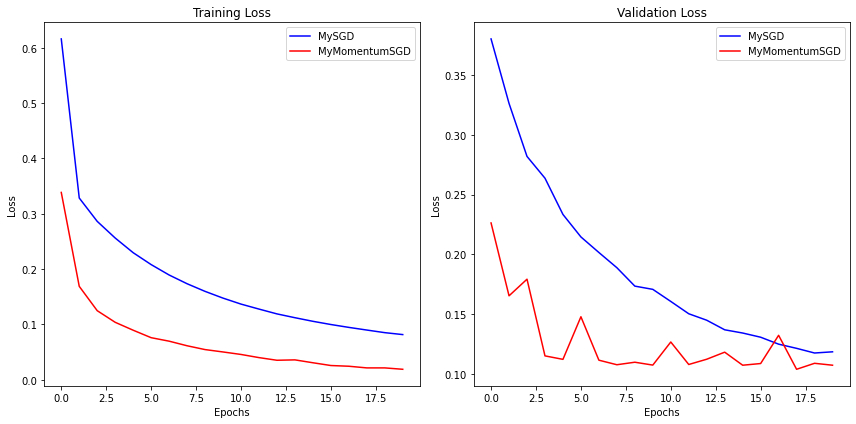

In [15]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_sgd, label="MySGD", color='blue')
plt.plot(train_loss_msgd, label="MyMomentumSGD", color='red')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_loss_sgd, label="MySGD", color='blue')
plt.plot(val_loss_msgd, label="MyMomentumSGD", color='red')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


The clear winner is MyMomentumSGD, which achieves the lowest validation loss and highest validation accuracy! Let's see if we can beat this result with the *Nesterov Accelerated Gradient* (NAG).

## Elevating Optimization with Nesterov Accelerated Gradient (NAG)

While traditional momentum has significantly improved the performance of our model, there's another optimization technique that can take it a step further: **Nesterov Accelerated Gradient (NAG)**. This refined form of momentum is akin to an expert skier who not only gathers speed when descending but also anticipates the layout of the slope ahead.

In essence, Nesterov Momentum enables our optimizer to "peek" into the future to adjust its trajectory more intelligently. This leads to more informed updates during training, thereby enhancing the convergence speed and potentially improving the final performance of the model.

### Mathematical Description

In Stochastic Gradient Descent (SGD) with standard momentum, the update rule is defined as:


$$v_{t+1} = \gamma v_{t} + \eta \nabla L(\theta_{t}) \, ,$$
$$\theta_{t+1} = \theta_{t} - v_{t+1} \, ,$$

where 
- $\theta_t$  is the parameter vector, 
- $\nabla L(\theta)$ is the gradient of the loss function $J$ with respect to $\theta$, 
- $\eta$  is the learning rate, 
- $\gamma$  is the momentum term, 
- and $v_t$ is the velocity vector.

In Nesterov Accelerated Gradient, the update rule is slightly modified to "peek" into the future:

$$v_{t+1} = \gamma v_{t} + \eta \nabla L(\theta_{t} - \gamma v_{t})$$
$$\theta_{t+1} = \theta_{t} - v_{t+1}$$

Notice that the gradient is evaluated at the "look-ahead" position $(\theta_{t} - \gamma v_{t})$, rather than the current position $\theta_{t}$. This subtle yet important change allows the optimizer to make more informed updates, effectively improving convergence properties. Feel free to discuss with your colleagues how this change in the gradient evaluation point could affect the performance of the optimizer. Are there similar techniques in other areas of mathematics that use a "look-ahead" strategy?

This also means that we need to compute the look-ahead gradient inside the step function of our optimizer class. For this reason, we suggest implementing a simplified version of the Nesterov Accelerated Gradient (NAG) optimizer, akin to PyTorch's original implementation.

### Simplified Nesterov Momentum in PyTorch

In the PyTorch implementation, a simplified version of the Nesterov momentum is used. The update rules look as follows:

$$
v_{t+1} = \gamma v_{t} + \nabla_{\theta} L(\theta_{t})
$$

$$
\text{corrected gradient} = \nabla_{\theta} L(\theta_{t}) + \gamma v_{t+1}
$$

$$
\theta_{t+1} = \theta_{t} - \eta \times \text{corrected gradient}
$$

This simplified version approximates the benefits of Nesterov's update by adding a "corrected" term $\gamma v_{t+1}$ to the current gradient, which serves as a form of "look-ahead". Although this does not strictly follow Nesterov's original formula, this approach is computationally simpler and has been found to work well in practice.

## Coding Exercise: (Simplified) Nesterov Accelerated Gradient (NAG)

In [6]:
class MyNesterovMomentumSGD:
    def __init__(self, params, learning_rate=0.01, momentum=0.9):
        self.params = list(params)
        self.lr = learning_rate
        self.momentum = momentum
        self.velocity = [torch.zeros_like(p.data) for p in self.params if p is not None]
        
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def step(self):
        for i, param in enumerate(self.params):
            if param.grad is None:
                continue

            # Update the running buffer (buf), similar to velocity
            ##### YOUR CODE HERE #####

            self.velocity[i].mul_(self.momentum).add_(param.grad, alpha=1.0)

            # Calculate the "corrected" gradient
            ##### YOUR CODE HERE #####
            corrected_gradient = param.grad + self.momentum * self.velocity[i]

            # Update the parameters
            ##### YOUR CODE HERE #####
            param.data.add_(corrected_gradient, alpha=-self.lr)

In [7]:
# Set hyperparameters
learning_rate = 0.01
num_epochs = 20

# Initialize model and optimizer
model_nesterov = SimpleNN().to(device)
optimizer_nesterov = MyNesterovMomentumSGD(model_nesterov.parameters(), learning_rate=learning_rate) # Here we use our own Nestrov Accelerated Gradient

# Train model
train_loss_nesterov = []
val_loss_nesterov = []
for epoch in range(num_epochs):
    loss = train_model(model_nesterov, train_loader, optimizer_nesterov, criterion, device)
    train_loss_nesterov.append(loss)
    
    val_loss, val_accuracy = evaluate_model(model_nesterov, val_loader, criterion, device)
    val_loss_nesterov.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/20, Training Loss: 0.3388, Validation Loss: 0.2052, Validation Accuracy: 0.9364
Epoch 2/20, Training Loss: 0.1659, Validation Loss: 0.1602, Validation Accuracy: 0.9531
Epoch 3/20, Training Loss: 0.1244, Validation Loss: 0.1349, Validation Accuracy: 0.9582
Epoch 4/20, Training Loss: 0.0988, Validation Loss: 0.1184, Validation Accuracy: 0.9646
Epoch 5/20, Training Loss: 0.0849, Validation Loss: 0.1139, Validation Accuracy: 0.9656
Epoch 6/20, Training Loss: 0.0733, Validation Loss: 0.1344, Validation Accuracy: 0.9609
Epoch 7/20, Training Loss: 0.0656, Validation Loss: 0.1217, Validation Accuracy: 0.9648
Epoch 8/20, Training Loss: 0.0579, Validation Loss: 0.1055, Validation Accuracy: 0.9685
Epoch 9/20, Training Loss: 0.0504, Validation Loss: 0.1014, Validation Accuracy: 0.9715
Epoch 10/20, Training Loss: 0.0449, Validation Loss: 0.1121, Validation Accuracy: 0.9687
Epoch 11/20, Training Loss: 0.0427, Validation Loss: 0.1010, Validation Accuracy: 0.9733
Epoch 12/20, Training Loss: 0.

Great! The Nesterov Accelerated Gradient (NAG) optimizer worked well on our simple classification problem. 

Here are some pre-computed results if you want to skip the training process. Simply uncomment the following code block and run it.

In [12]:
# NOTE: Uncomment the following lines to use the pre-computed results
# train_loss_nesterov = [
#     0.3388, 0.1659, 0.1244, 0.0988, 0.0849, 0.0733, 0.0656, 0.0579, 0.0504, 0.0449, 
#     0.0427, 0.0366, 0.0324, 0.0302, 0.0277, 0.0255, 0.0210, 0.0189, 0.0163, 0.0153
# ]
# val_loss_nesterov = [
#     0.2052, 0.1602, 0.1349, 0.1184, 0.1139, 0.1344, 0.1217, 0.1055, 0.1014, 0.1121, 
#     0.1010, 0.1058, 0.1033, 0.1149, 0.1215, 0.1118, 0.1019, 0.1068, 0.0974, 0.0972
# ]

# SGD vs. (Nesterov) Momentum

Again, let's compare our new results obtained through the Nesterov Accelerated Gradient (NAG) optimizer with the previous optimizers.

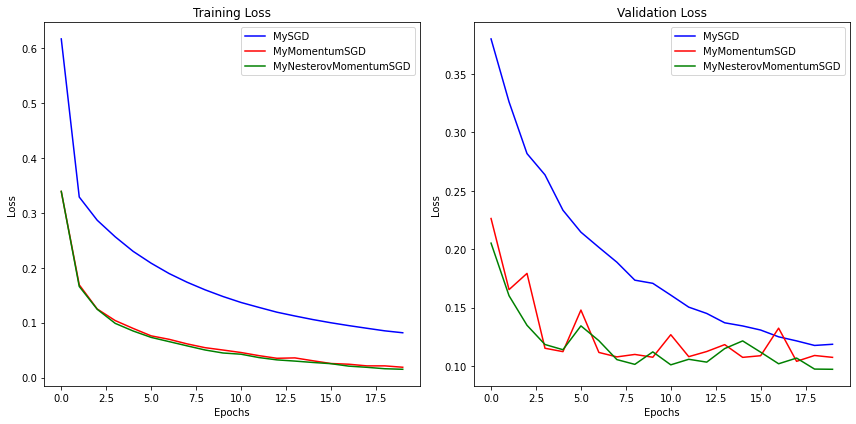

In [17]:
# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_sgd, label="MySGD", color='blue')
plt.plot(train_loss_msgd, label="MyMomentumSGD", color='red')
plt.plot(train_loss_nesterov, label="MyNesterovMomentumSGD", color='green')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_loss_sgd, label="MySGD", color='blue')
plt.plot(val_loss_msgd, label="MyMomentumSGD", color='red')
plt.plot(val_loss_nesterov, label="MyNesterovMomentumSGD", color='green')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


Seems like Nesterov Momentum and the traditional momentum are very similar and both beat the traditional SGD. In order to rigorously compare the optimizers, we would need to run multiple experiments and perform statistical tests. We could also increase the complexity of the learning task which would make the differences more apparent. However, for the sake of simplicity, we will not do this here.


## Unlocking Adaptive Gradient Descent: The AdaGrad Approach

 *AdaGrad*, short for *"Adaptive Gradient"*, is an optimization algorithm designed by Duchi et al.<sup>[1](https://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)</sup> in 2011 to improve the performance and training speed of machine learning algorithms. Unlike the previous optimizers, which use a constant learning rate for all parameters, AdaGrad adapts the learning rates during training. This can be particularly useful when dealing with sparse data or features that appear infrequently. For instance, Pennington et al. used Adagrad to train GloVe<sup>[3](https://nlp.stanford.edu/projects/glove/)</sup><sup>[,4](https://www.ruder.io/optimizing-gradient-descent/)</sup> word embeddings because rare words require much larger updates than frequent ones.


### How Does AdaGrad Work?

The key idea behind AdaGrad is to adjust the learning rates based on the past gradients for each parameter individually. Specifically, it keeps track of the sum of squares of past gradients and adjusts the learning rate in a way that is inversely proportional to the square root of this sum.

Mathematically, the AdaGrad update rule for each parameter $ \theta_t $ can be represented as:

$$
\begin{aligned}
g_t &= \nabla_{\theta} L(\theta_t) , \\
G_{t, ii} &= G_{t-1, ii} + g_{t,i}^2 , \\
\theta_{t+1} &= \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \cdot g_t
\end{aligned}
$$

Where:

- $ g_t $ represents the gradient of the loss function at time step $ t $.
- $ G_t $ is the diagonal matrix that stores the sum of squares of the past gradients. You can also store the elements of the diagonal matrix in a vector.
- $ \epsilon $ is a smoothing term to prevent division by zero (usually set to a small value like $ 1 \times 10^{-8} $).
- $ \eta $ is the global learning rate, usually set to $ 0.01 $.

### Why AdaGrad?

- Adaptive Learning Rate: AdaGrad adapts the learning rate during training. This can be beneficial for loss functions that have different shapes along different dimensions.
- Sparse Data: AdaGrad can perform well on problems with sparse features where the importance of each feature varies significantly. This is because rarely occurring features get a higher learning rate, thus AdaGrad can adapt quickly to more informative features.
- Simple and Easy to Implement: Similar to SGD, AdaGrad is easy to implement and computationally efficient.

However, it's worth noting that AdaGrad's aggressive decrease in the learning rate can be a double-edged sword. While it often performs well on convex problems, the continually decreasing learning rate can cause the algorithm to converge prematurely when optimizing non-convex functions, as often encountered in deep learning. There are several extensions of AdaGrad that try to address this issue, such as RMSProp and Adam, which we will discuss later.

Now, let's experiment with AdaGrad and compare it against our previous results!

In [38]:
class MyAdaGrad:
    def __init__(self, params, lr=0.01, epsilon=1e-8):
        self.params = list(params)
        self.lr = lr
        self.eps = epsilon
        self.g_squared = {}  # dictionary to store squared gradients for each parameter

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

    def step(self):
        for param in self.params:
            if param.grad is None:
                continue
            
            # Initialize squared gradient memory for the parameter if it doesn't exist
            if param not in self.g_squared:
                # NOTE: The key of the dictionary is the parameter itself
                self.g_squared[param] = torch.zeros_like(param.data)
            
            # Update squared gradient memory
            ##### YOUR CODE HERE #####
            self.g_squared[param] += param.grad.data ** 2

            # Update parameter
            ##### YOUR CODE HERE #####
            param.data -= self.lr * param.grad.data / (torch.sqrt(self.g_squared[param]) + self.eps)

In [39]:
# Set hyperparameters
learning_rate = 0.01
num_epochs = 20
# Initialize model and optimizer
model_adagrad = SimpleNN().to(device)
# optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=learning_rate)
optimizer_adagrad = MyAdaGrad(model_adagrad.parameters(), lr=learning_rate)
# Train model
train_loss_adagrad = []
val_loss_adagrad = []
for epoch in range(num_epochs):
    loss = train_model(model_adagrad, train_loader, optimizer_adagrad, criterion, device)
    train_loss_adagrad.append(loss)
    
    val_loss, val_accuracy = evaluate_model(model_adagrad, val_loader, criterion, device)
    val_loss_adagrad.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/20, Training Loss: 0.3917, Validation Loss: 0.2906, Validation Accuracy: 0.9150
Epoch 2/20, Training Loss: 0.2626, Validation Loss: 0.2488, Validation Accuracy: 0.9260
Epoch 3/20, Training Loss: 0.2291, Validation Loss: 0.2260, Validation Accuracy: 0.9338
Epoch 4/20, Training Loss: 0.2080, Validation Loss: 0.2097, Validation Accuracy: 0.9380
Epoch 5/20, Training Loss: 0.1913, Validation Loss: 0.1939, Validation Accuracy: 0.9431
Epoch 6/20, Training Loss: 0.1781, Validation Loss: 0.1839, Validation Accuracy: 0.9468
Epoch 7/20, Training Loss: 0.1672, Validation Loss: 0.1749, Validation Accuracy: 0.9484
Epoch 8/20, Training Loss: 0.1590, Validation Loss: 0.1686, Validation Accuracy: 0.9500
Epoch 9/20, Training Loss: 0.1517, Validation Loss: 0.1619, Validation Accuracy: 0.9519
Epoch 10/20, Training Loss: 0.1452, Validation Loss: 0.1576, Validation Accuracy: 0.9532
Epoch 11/20, Training Loss: 0.1397, Validation Loss: 0.1534, Validation Accuracy: 0.9545
Epoch 12/20, Training Loss: 0.

In [7]:
# NOTE: Uncomment if you want to use the pre-computed results
# train_loss_adagrad = [0.3917, 0.2626, 0.2291, 0.2080, 0.1913, 0.1781, 0.1672, 0.1590, 0.1517, 0.1452, 0.1397, 0.1346, 0.1300, 0.1259, 0.1220, 0.1188, 0.1155, 0.1128, 0.1100, 0.1074]
# val_loss_adagrad = [0.2906, 0.2488, 0.2260, 0.2097, 0.1939, 0.1839, 0.1749, 0.1686, 0.1619, 0.1576, 0.1534, 0.1539, 0.1467, 0.1434, 0.1393, 0.1377, 0.1345, 0.1334, 0.1317, 0.1317]

## Comparing Results

Let's plot the training and validation losses for all of our optimizers and compare them.


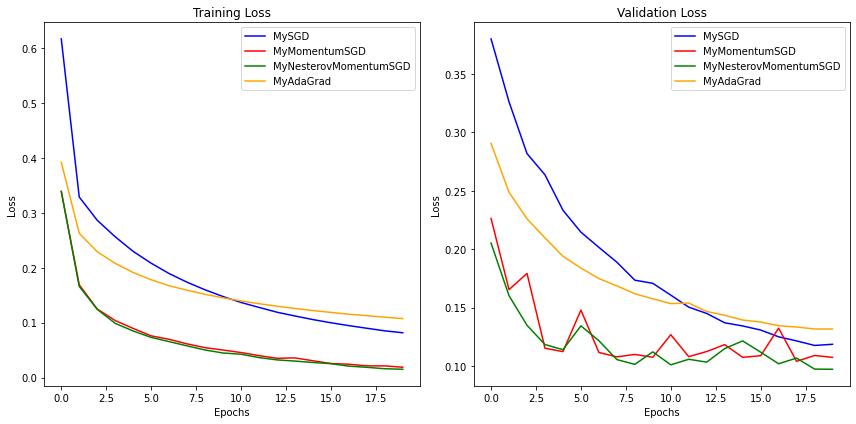

In [40]:
# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_sgd, label="MySGD", color='blue')
plt.plot(train_loss_msgd, label="MyMomentumSGD", color='red')
plt.plot(train_loss_nesterov, label="MyNesterovMomentumSGD", color='green')
plt.plot(train_loss_adagrad, label="MyAdaGrad", color='orange')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_loss_sgd, label="MySGD", color='blue')
plt.plot(val_loss_msgd, label="MyMomentumSGD", color='red')
plt.plot(val_loss_nesterov, label="MyNesterovMomentumSGD", color='green')
plt.plot(val_loss_adagrad, label="MyAdaGrad", color='orange')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


Interesting! If AdaGrad performs worse than the traditional SGD optimizer in your setup, this is probably due to the fact that the learning rate decreases too quickly and the algorithm converges prematurely. However, AdaGrad can be very useful for sparse datasets, where it can significantly improve the performance. Feel free to compare your results with your colleagues and discuss the differences.

## Synchronizing the Best of Both Worlds: Adaptive Moment Estimation (Adam)

After exploring AdaGrad's capabilities in adapting the learning rates based on the historical gradients, let's shift our focus to another powerful optimization algorithm — **Adam**<sup>[1](https://arxiv.org/abs/1412.6980)</sup>, which stands for "*Adaptive Moment Estimation*". Adam is often lauded as a "best of both worlds" algorithm, synthesizing ideas from Momentum and AdaGrad to deliver an optimizer that is both fast and accurate. Unlike traditional algorithms, which use a fixed learning rate for all parameters, Adam calculates adaptive learning rates for each individual parameter. It goes a step beyond AdaGrad by not just adapting learning rates based on the historical squared gradients but also incorporating the concept of momentum by maintaining an exponentially decaying average of past gradients.

Mathematically, the Adam update rule can be represented as:

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t 
$$
$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$
$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}
$$
$$
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$
$$
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \cdot \hat{m}_t
$$

Where:

- $g_t$ represents the gradient of the loss at time step $t$.
- $ m_t $ and $v_t$ are estimates of the first moment (the mean) and the second moment (the uncentered variance) of the gradients respectively.
- $\beta_1$ and $\beta_2$ are the exponential decay rates for these moment estimates.
- $\hat{m}_t$ and $\hat{v}_t$ are bias-corrected estimates of the first and second moments.
- $\epsilon$ is a smoothing term to prevent division by zero (usually set to a small value like $1 \times 10^{-8}$).
- $ \eta$ is the learning rate.

In [29]:
class MyAdam:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}  # Placeholder for the first moment vector
        self.v = {}  # Placeholder for the second moment vector
        self.t = 0   # Initialize time step

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        self.t += 1  # Increment timestep
        for p in self.params:
            if p.grad is None:
                continue
            
            # Initialize moment vectors if encountering this parameter for the first time
            if p not in self.m:
                self.m[p] = torch.zeros_like(p.data)
            if p not in self.v:
                self.v[p] = torch.zeros_like(p.data)

            # NOTE
            # You can access the gradient of the parameter by p.grad.data
            # To update or access the first and second moment vectors, use self.m[p] and self.v[p] respectively

            # Update biased first and second moment estimates
            ##### YOUR CODE HERE #####
            self.m[p] = self.beta1 * self.m[p] + (1 - self.beta1) * p.grad.data
            self.v[p] = self.beta2 * self.v[p] + (1 - self.beta2) * p.grad.data ** 2
            
            # Compute bias-corrected first and second moment estimates
            ##### YOUR CODE HERE #####
            m_hat = self.m[p] / (1 - self.beta1 ** self.t)
            v_hat = self.v[p] / (1 - self.beta2 ** self.t)
            
            # Update the parameter
            ##### YOUR CODE HERE #####
            p.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)


### Start Training with MyAdam

In [31]:
# Set hyperparameters
learning_rate = 0.001
num_epochs = 20
# Initialize model and optimizer
model_adam = SimpleNN().to(device)
# Here we use our own Adam optimizer
optimizer_adam = MyAdam(model_adam.parameters(), lr=learning_rate)
# Train model
train_loss_adam = []
val_loss_adam = []
for epoch in range(num_epochs):
    loss = train_model(model_adam, train_loader, optimizer_adam, criterion, device)
    train_loss_adam.append(loss)
    
    val_loss, val_accuracy = evaluate_model(model_adam, val_loader, criterion, device)
    val_loss_adam.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/20, Training Loss: 0.3717, Validation Loss: 0.2171, Validation Accuracy: 0.9369
Epoch 2/20, Training Loss: 0.1889, Validation Loss: 0.1539, Validation Accuracy: 0.9544
Epoch 3/20, Training Loss: 0.1396, Validation Loss: 0.1564, Validation Accuracy: 0.9504
Epoch 4/20, Training Loss: 0.1137, Validation Loss: 0.1391, Validation Accuracy: 0.9593
Epoch 5/20, Training Loss: 0.1009, Validation Loss: 0.1138, Validation Accuracy: 0.9668
Epoch 6/20, Training Loss: 0.0875, Validation Loss: 0.1116, Validation Accuracy: 0.9689
Epoch 7/20, Training Loss: 0.0775, Validation Loss: 0.1151, Validation Accuracy: 0.9696
Epoch 8/20, Training Loss: 0.0713, Validation Loss: 0.1105, Validation Accuracy: 0.9692
Epoch 9/20, Training Loss: 0.0653, Validation Loss: 0.1270, Validation Accuracy: 0.9639
Epoch 10/20, Training Loss: 0.0603, Validation Loss: 0.1099, Validation Accuracy: 0.9705
Epoch 11/20, Training Loss: 0.0540, Validation Loss: 0.1308, Validation Accuracy: 0.9662
Epoch 12/20, Training Loss: 0.

In [8]:
# NOTE: Uncomment if you want to use the pre-computed results
# train_loss_adam = [0.3717, 0.1889, 0.1396, 0.1137, 0.1009, 0.0875, 0.0775, 0.0713, 0.0653, 0.0603, 0.0540, 0.0520, 0.0463, 0.0440, 0.0406, 0.0387, 0.0364, 0.0365, 0.0327, 0.0323]
# val_loss_adam = [0.2171, 0.1539, 0.1564, 0.1391, 0.1138, 0.1116, 0.1151, 0.1105, 0.1270, 0.1099, 0.1308, 0.1335, 0.1293, 0.1182, 0.1273, 0.1296, 0.1309, 0.1661, 0.1474, 0.1467]

# Results

Alright! We got our last results for this session. Let's plot the training and validation losses for all of our optimizers and compare them.

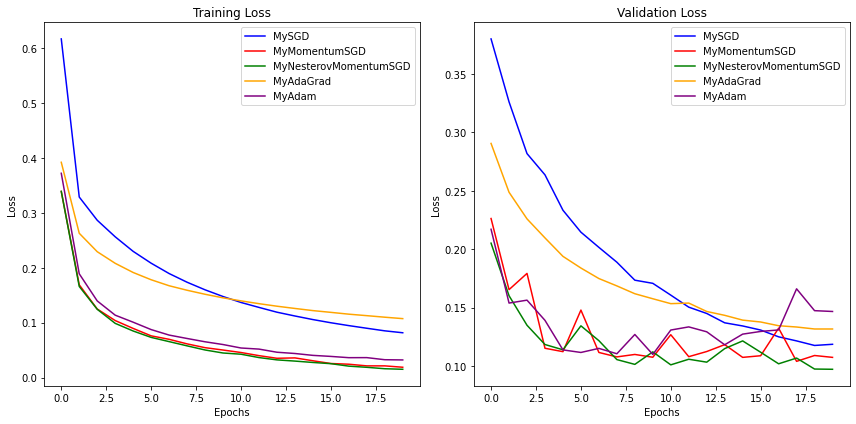

In [13]:
import matplotlib.pyplot as plt
# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_sgd, label="MySGD", color='blue')
plt.plot(train_loss_msgd, label="MyMomentumSGD", color='red')
plt.plot(train_loss_nesterov, label="MyNesterovMomentumSGD", color='green')
plt.plot(train_loss_adagrad, label="MyAdaGrad", color='orange')
plt.plot(train_loss_adam, label="MyAdam", color='purple')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_loss_sgd, label="MySGD", color='blue')
plt.plot(val_loss_msgd, label="MyMomentumSGD", color='red')
plt.plot(val_loss_nesterov, label="MyNesterovMomentumSGD", color='green')
plt.plot(val_loss_adagrad, label="MyAdaGrad", color='orange')
plt.plot(val_loss_adam, label="MyAdam", color='purple')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


# Final Thoughts and Conclusion

In this notebook, we successfully implemented and compared five prevalent first-order optimization methods — SGD, Momentum, Nesterov, Adagrad, and Adam — on the MNIST dataset. Each method has its own merits and drawbacks, which became evident through the performance metrics and convergence behavior observed in the final plots.

By no means is this an exhaustive list of optimization algorithms. There are many more algorithms that we did not cover in this notebook, such as Adadelta, RMSProp, and Nadam. We encourage you to explore these algorithms and compare them with the ones we covered here. Also note that the performance of these algorithms depends on the dataset and the model architecture. Therefore, it is important to experiment with different optimizers and hyperparameters to find the best combination for your problem.

# Questions and Discussion Points

1. **Which Optimizer Outperformed Others?:** Based on the final plots and performance metrics, which optimization algorithm seemed to perform the best on the MNIST dataset? Are the results consistent across different metrics like speed of convergence, final loss, and accuracy?

2. **Areas for Improvement:** Can you think of ways to improve each of the optimization algorithms? For example, could parameter tuning further enhance performance? Does a global Learning Rate Scheduler make sense for the adaptive methods? What about other hyperparameters like the momentum coefficient? Feel free to experiment with different hyperparameters and see how they affect the performance.

3. **Cross-disciplinary Dialogue:** We invite you to discuss your findings and thoughts with your colleagues. What are some potential real-world applications where one optimization algorithm may be more suitable than others?

4. **Further Exploration:** Would you like to explore other optimization algorithms not covered in this notebook? Feel free to implement them and see how they compare.

Engaging in these discussions and explorations will not only deepen your understanding of optimization algorithms but also provide you with practical skills that can be applied in various real-world scenarios. We encourage active participation and sharing of insights among all participants.

# References

- Overview: [An overview of gradient descent optimization algorithms](https://www.ruder.io/optimizing-gradient-descent/) by Sebastian Ruder ([arXiv version](https://arxiv.org/pdf/1609.04747.pdf)) — Very useful!
- AdaGrad: [Adaptive Subgradient Methods for Online Learning and Stochastic Optimization](https://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf) by Duchi et al.
- [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980) by Kingma et al.
- [CS231n: Optimization Algorithms](https://cs231n.github.io/optimization-1/) - Stanford Course
- [CS231n: Neural Networks Part 2](https://cs231n.github.io/neural-networks-2/) - Stanford Course
- [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) by  François Chollet 
- [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow et al.